<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Exam_preparation/Time_series_forecasting_eth_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Download ETH dataset
!wget https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/Datasets/ETH_Coindesk.csv

--2021-09-01 10:06:31--  https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/Datasets/ETH_Coindesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115669 (113K) [text/plain]
Saving to: ‘ETH_Coindesk.csv’

ETH_Coindesk.csv    100%[===================>] 112.96K  --.-KB/s    in 0.02s   

2021-09-01 10:06:32 (5.61 MB/s) - ‘ETH_Coindesk.csv’ saved [115669/115669]



In [2]:
#Import Data
import pandas as pd
df = pd.read_csv("/content/ETH_Coindesk.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2016-12-15,ETH,8.195936,8.394537,8.440725,8.044697
2016-12-16,ETH,7.836525,8.195936,8.206139,7.694463
2016-12-17,ETH,7.709642,7.836525,7.892591,7.699776
2016-12-18,ETH,7.813304,7.709642,7.939579,7.495653
2016-12-19,ETH,7.735086,7.813304,7.926575,7.690697


In [3]:
#Get more info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2016-12-15 to 2021-08-31
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             1706 non-null   object 
 1   Closing Price (USD)  1706 non-null   float64
 2   24h Open (USD)       1706 non-null   float64
 3   24h High (USD)       1706 non-null   float64
 4   24h Low (USD)        1706 non-null   float64
dtypes: float64(4), object(1)
memory usage: 80.0+ KB


In [4]:
#How many samples in the datset
len(df)

1706

In [5]:
#Use only the ETH closing price and rename columns
ether_price = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)": "Price"})
ether_price.head()

,Price
Date,
2016-12-15,8.195936
2016-12-16,7.836525
2016-12-17,7.709642
2016-12-18,7.813304
2016-12-19,7.735086


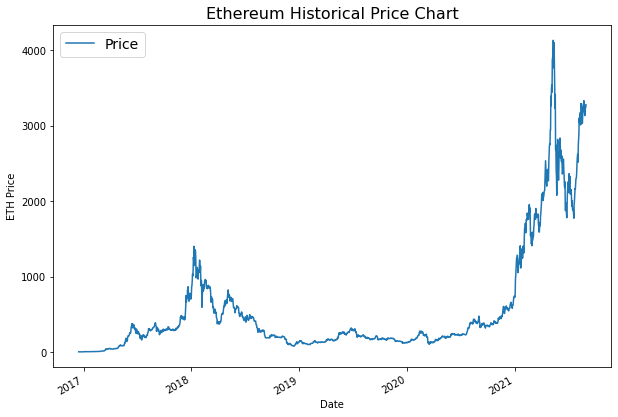

In [6]:
#Plot Ether price
import matplotlib.pyplot as plt
ether_price.plot(figsize=(10,7))
plt.ylabel("ETH Price")
plt.title("Ethereum Historical Price Chart", fontsize=16)
plt.legend(fontsize=14)

In [7]:
#Get ETH price and date array
timesteps = ether_price.index.to_numpy()
prices = ether_price["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2016-12-15T00:00:00.000000000', '2016-12-16T00:00:00.000000000',
        '2016-12-17T00:00:00.000000000', '2016-12-18T00:00:00.000000000',
        '2016-12-19T00:00:00.000000000', '2016-12-20T00:00:00.000000000',
        '2016-12-21T00:00:00.000000000', '2016-12-22T00:00:00.000000000',
        '2016-12-23T00:00:00.000000000', '2016-12-24T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([8.195936, 7.836525, 7.709642, 7.813304, 7.735086, 7.601047,
        7.675313, 7.569866, 7.601819, 7.221961]))

In [8]:
#Create train and test sets
split_size = int(0.8 * len(prices))
y_train, x_train = prices[:split_size], timesteps[:split_size]
y_test, x_test = prices[split_size:], timesteps[split_size:]
len(x_train), len(x_test), len(y_train), len(y_test)

(1364, 342, 1364, 342)

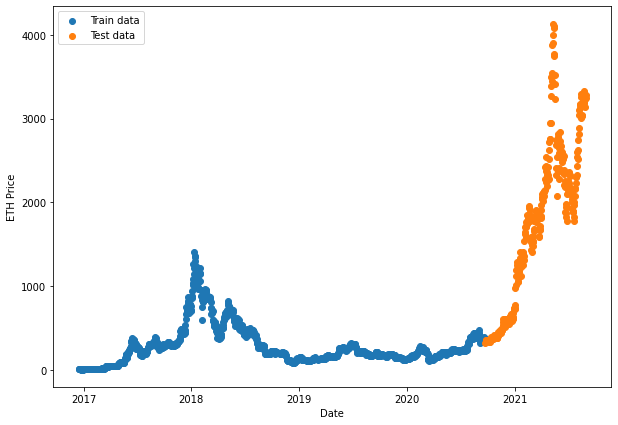

In [9]:
#Plot the train and test split
plt.figure(figsize=(10,7))
plt.scatter(x_train, y_train, label="Train data")
plt.scatter(x_test, y_test, label="Test data")
plt.xlabel("Date")
plt.ylabel("ETH Price")
plt.legend()

In [10]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps against values
  Parameters
  ----------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  ende: where to ende the plot (setting a value will index from end of timesteps & values)
  label: label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Values")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

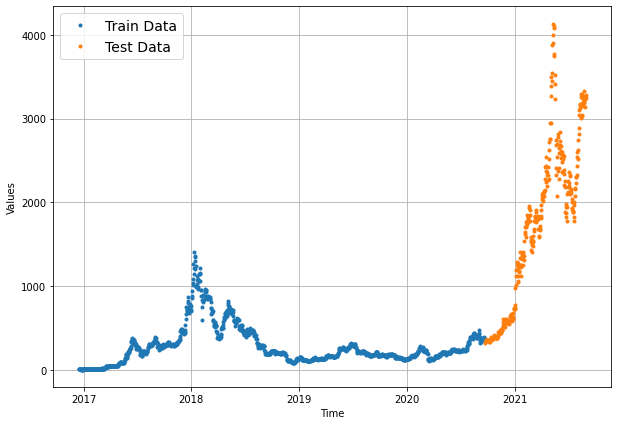

In [11]:
plt.figure(figsize=(10,7))
plot_time_series(x_train, y_train, label="Train Data")
plot_time_series(x_test, y_test, label="Test Data")

In [12]:
import numpy as np

def make_windows(x, window_size=7, horizon=1):
  """
  Turn a 1D array into a 2D array of sequential windows of window_size
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create 2D array of multiple window steps (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T #create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = windowed_array[:, :-horizon], windowed_array[:, -horizon:]

  return windows, labels

In [13]:
prices[:10], timesteps[:10]

(array([8.195936, 7.836525, 7.709642, 7.813304, 7.735086, 7.601047,
        7.675313, 7.569866, 7.601819, 7.221961]),
 array(['2016-12-15T00:00:00.000000000', '2016-12-16T00:00:00.000000000',
        '2016-12-17T00:00:00.000000000', '2016-12-18T00:00:00.000000000',
        '2016-12-19T00:00:00.000000000', '2016-12-20T00:00:00.000000000',
        '2016-12-21T00:00:00.000000000', '2016-12-22T00:00:00.000000000',
        '2016-12-23T00:00:00.000000000', '2016-12-24T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [14]:
HORIZON = 1
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1699, 1699)

In [15]:
for i in range(5):
  print(f"WIndow: {full_windows[i]}, Label: {full_labels[i]}")

WIndow: [8.195936 7.836525 7.709642 7.813304 7.735086 7.601047 7.675313], Label: [7.569866]
WIndow: [7.836525 7.709642 7.813304 7.735086 7.601047 7.675313 7.569866], Label: [7.601819]
WIndow: [7.709642 7.813304 7.735086 7.601047 7.675313 7.569866 7.601819], Label: [7.221961]
WIndow: [7.813304 7.735086 7.601047 7.675313 7.569866 7.601819 7.221961], Label: [7.256569]
WIndow: [7.735086 7.601047 7.675313 7.569866 7.601819 7.221961 7.256569], Label: [7.260191]


In [16]:
#Function for creating train and test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [17]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels) 

(1359, 340, 1359, 340)

In [18]:
import tensorflow as tf
import os
#Function for implementing a model checkpoint
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                              verbose=0, # only output a limited amount of text
                                              save_best_only=True) # save only the best model to file

In [19]:
#Create an evaluation function
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)

## Model 1: Dense model - W30/H1

In [21]:
#Build the model

model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
                               
], name="model_1_dense")

In [22]:
#Compile the model
model_1.compile(loss="mae", optimizer="Adam", metrics=["mae", "mse"])

In [23]:
#Fit the model
history_model_1 = model_1.fit(train_windows, train_labels,
                              epochs=100,
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_1.name)])

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: mod

In [24]:
#Evaluate the model
model_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 72.2932 - mae: 72.2932 - mse: 12865.1953


[72.293212890625, 72.293212890625, 12865.1953125]

In [25]:
#Load the best model
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 5ms/step - loss: 71.7637 - mae: 71.7637 - mse: 12543.5137


[71.76368713378906, 71.76368713378906, 12543.513671875]

In [26]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  --------
  model: trained model
  input_data: windowd input data (same kind of data model was trained on)

  Returns model predictions on input data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [27]:
#make predictions
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([342.98212, 353.40063, 355.5383 , 354.8855 , 364.09125, 360.7897 ,
       360.01868, 354.64923, 348.13687, 347.51245], dtype=float32)>

In [28]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 71.76369, 'mape': 71.76369, 'mse': 12543.515, 'rmse': 111.99783}

## Model 1: Dense model - W15/H1

In [29]:
#Window data
HORIZON = 1
WINDOW_SIZE = 15
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1691, 1691)

In [30]:
#Split data into train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels) 

(1352, 339, 1352, 339)

In [31]:
#Build the model 
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_2_dense")

In [32]:
#Compile the model
model_2.compile(loss="mse", optimizer="Adam", metrics=["mse", "mae"])

In [33]:
#Fit the model 
history_model_2 = model_2.fit(train_windows, train_labels, 
                              epochs=100,
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [34]:
#Evaluate the model 
model_2.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 13628.0371 - mse: 13628.0371 - mae: 81.1907


[13628.037109375, 13628.037109375, 81.19066619873047]

In [35]:
#Load best performing model 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 13208.0029 - mse: 13208.0029 - mae: 75.6301


[13208.0029296875, 13208.0029296875, 75.63007354736328]

In [36]:
#Get forecast predictions
model_2_preds = make_preds(model_2, test_windows)

In [37]:
#Evaluate results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 75.630066, 'mape': 75.630066, 'mse': 13208.003, 'rmse': 114.92608}

## Model 3: Conv1D - W30/H1

In [38]:
#Window data
HORIZON = 1
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1676, 1676)

In [39]:
#Split data into train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels) 

(1340, 336, 1340, 336)

In [40]:
#Build the model 
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                               layers.Dense(HORIZON)
], name="model_3_Conv1D")

In [41]:
#Compile the model
model_3.compile(loss="mse", optimizer="Adam", metrics=["mse", "mae"])

In [42]:
#Fit the model
history_model_3 = model_3.fit(train_windows, train_labels,
                              epochs=100,
                              verbose=0,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_Conv1D/assets
INFO:tensorflow:Assets wr

In [43]:
#Evaluate the model
model_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 8ms/step - loss: 26031.2500 - mse: 26031.2500 - mae: 119.2315


[26031.25, 26031.25, 119.23152923583984]

In [44]:
#Load best performing model 
model_3 = tf.keras.models.load_model("model_experiments/model_3_Conv1D/")
model_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 9ms/step - loss: 16576.9473 - mse: 16576.9473 - mae: 84.9421


[16576.947265625, 16576.947265625, 84.94210052490234]

In [45]:
#Get forecast predictions
model_3_preds = make_preds(model_3, test_windows)

In [46]:
#Evaluate results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': 84.9421, 'mape': 84.9421, 'mse': 16576.947, 'rmse': 128.7515}

## Model 4: LSTM - W30/H1

In [47]:
#Build the model 
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.LSTM(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_4_LSTM")

In [48]:
#Compile the model 
model_4.compile(loss="mse", optimizer="Adam", metrics=["mse", "mae"])

In [49]:
#Fit the model 
history_model_4 = model_4.fit(train_windows, train_labels, 
                              epochs=100,
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_LSTM/assets
INFO:tensorflow:Assets written to: model_experiment

In [50]:
#Evaluate the model 
model_4.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 6ms/step - loss: 19426.4219 - mse: 19426.4219 - mae: 91.0380


[19426.421875, 19426.421875, 91.03800201416016]

In [51]:
#Load best model 
model_4 = tf.keras.models.load_model("model_experiments/model_4_LSTM/")
model_4.evaluate(test_windows, test_labels)

11/11 [==============================] - 1s 6ms/step - loss: 19426.4219 - mse: 19426.4219 - mae: 91.0380


[19426.421875, 19426.421875, 91.03800201416016]

In [52]:
#Get forecast predictions
model_4_preds = make_preds(model_4, test_windows)

In [53]:
#Evaluate on forecast predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 91.038, 'mape': 91.038, 'mse': 19426.422, 'rmse': 139.3787}

## Compare Experiments

In [54]:
model_results = pd.DataFrame({"model_1_dense_w30_h1": model_1_results,
                              "model_2_dense_w15_h1": model_2_results,
                              "model_3_Conv1D_w30_h1": model_3_results,
                              "model_4_LSTM_w30_h1": model_4_results}).T
model_results

,mae,mse,rmse,mape
model_1_dense_w30_h1,71.763687,12543.514648,111.997833,71.763687
model_2_dense_w15_h1,75.630066,13208.002930,114.926079,75.630066
model_3_Conv1D_w30_h1,84.942101,16576.947266,128.751495,84.942101
model_4_LSTM_w30_h1,91.038002,19426.421875,139.378693,91.038002


In [55]:
model_results[["mae"]].sort_values(by="mae")

,mae
model_1_dense_w30_h1,71.763687
model_2_dense_w15_h1,75.630066
model_3_Conv1D_w30_h1,84.942101
model_4_LSTM_w30_h1,91.038002


## Model 5: Conv1D_Advanced - W30/H1

In [56]:
tf.random.set_seed(42)

#Build the model 

model_5 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Conv1D(filters=32, kernel_size=2, activation="relu", padding="causal"),
                               layers.Dropout(0.2),
                               layers.Conv1D(filters=16, kernel_size=2, activation="relu", padding="causal"),
                               layers.Dropout(0.2),
                               layers.MaxPooling1D(2, padding="same"),
                               layers.Flatten(),
                               layers.Dense(HORIZON) 
], name="model_5_Conv1D_Advanced")

In [57]:
#Compile the model 
model_5.compile(loss="mse", optimizer="Adam", metrics=["mse", "mae"])

In [58]:
#Fit the model 
history_model_5 = model_5.fit(train_windows, train_labels, 
                              epochs=100, 
                              batch_size=128, 
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_Advanced

In [59]:
#Evaluate the model 
model_5.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 8ms/step - loss: 29534.3652 - mse: 29534.3652 - mae: 127.3453


[29534.365234375, 29534.365234375, 127.34525299072266]

In [60]:
#Load best model 
model_5 = tf.keras.models.load_model("model_experiments/model_5_Conv1D_Advanced/")
model_5.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 7ms/step - loss: 23535.0957 - mse: 23535.0957 - mae: 105.5046


[23535.095703125, 23535.095703125, 105.504638671875]

In [61]:
#Make future predictions
model_5_preds = make_preds(model_5, test_windows)

In [62]:
#Evaluate on forecast predictions
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 105.50462, 'mape': 105.50462, 'mse': 23535.098, 'rmse': 153.41153}

In [63]:
def plot_mae_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  mae = history.history["mae"]
  val_mae = history.history["val_mae"]
  plt.figure(figsize=(10,7))
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.title("Train vs validation loss")
  plt.grid()
  plt.legend()
  plt.figure(figsize=(10, 7))
  plt.plot(mae, label="mae")
  plt.plot(val_mae, label="val_mae")
  plt.title("Mae vs Validation mae")
  plt.grid()
  plt.legend()

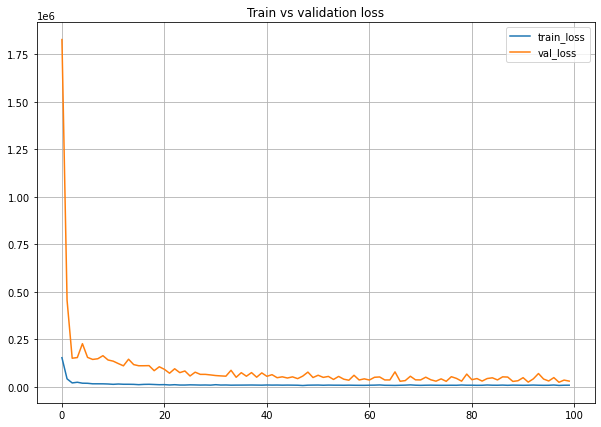

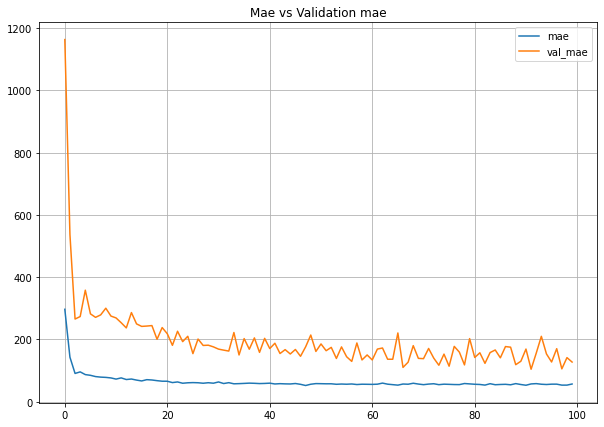

In [64]:
plot_mae_loss_curves(history_model_5)

##Model 6: GRU - W10/H1

In [65]:
#Window data
HORIZON = 1
WINDOW_SIZE = 10
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1696, 1696)

In [66]:
#Split data into train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels) 

(1356, 340, 1356, 340)

In [83]:
tf.random.set_seed(42)

#Build the model 
model_6 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.GRU(20, return_sequences=True),
                               layers.GRU(20),
                               layers.Dropout(0.2),
                               layers.Dense(HORIZON)                          
], name="model_6_GRU")

In [84]:
#Compile the model
model_6.compile(loss="mse", optimizer="Adam", metrics=["mse", "mae"])

In [86]:
#Fit the model 
history_model_6 = model_6.fit(train_windows, train_labels, 
                              epochs=100, 
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows, test_labels))

In [87]:
#Evaluate the model 
model_6.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 4ms/step - loss: 3699703.7500 - mse: 3699703.7500 - mae: 1656.8215


[3699703.75, 3699703.75, 1656.821533203125]

In [88]:
#Make future predictions
model_6_preds = make_preds(model_6, test_windows)

In [89]:
#Evaluate on future predictions
model_6_results = evaluate_preds(tf.squeeze(test_labels), model_6_preds)
model_6_results

{'mae': 1656.8215, 'mape': 1656.8215, 'mse': 3699703.8, 'rmse': 1923.4614}

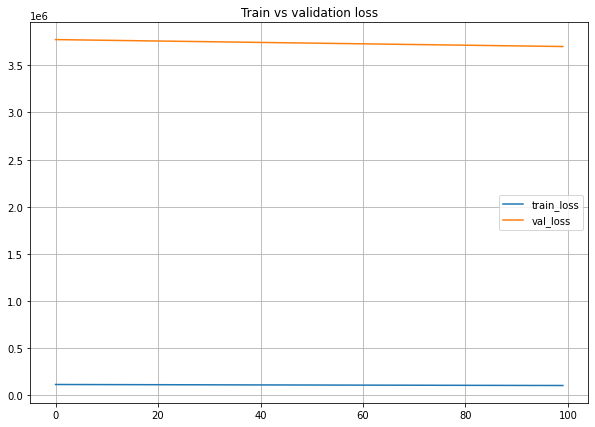

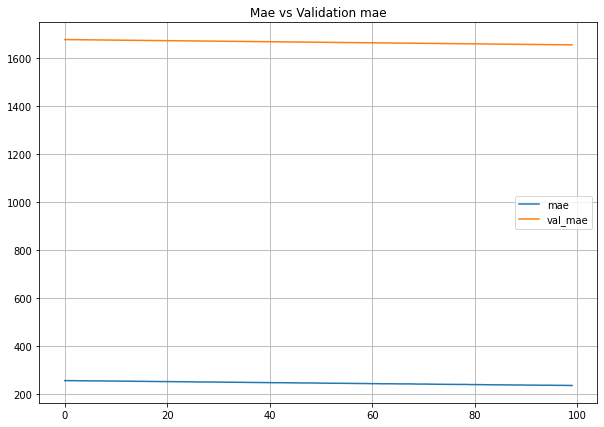

In [90]:
#Plot the learning curve
plot_mae_loss_curves(history_model_6)

## Model 7: GRU - W30/H1

In [91]:
#Window data
HORIZON = 1
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
#Split data into train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1340, 336, 1340, 336)

In [101]:
tf.random.set_seed(42)

#Build the model 
model_7 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.GRU(20),
                               layers.Dropout(0.2),
                               layers.Dense(HORIZON)                          
], name="model_7_GRU")

In [102]:
# Compile the model
model_7.compile(loss="mse", optimizer="Adam", metrics=["mse", "mae"])

In [103]:
#Fit the model 
history_model_7 = model_7.fit(train_windows, train_labels, 
                              epochs=100, 
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows, test_labels))

In [104]:
#Evaluate the model 
model_7.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 5ms/step - loss: 3840595.7500 - mse: 3840595.7500 - mae: 1701.9460


[3840595.75, 3840595.75, 1701.946044921875]

In [105]:
#Make future predictions
model_7_preds = make_preds(model_7, test_windows)

#Evaluate on future predictions
model_7_results = evaluate_preds(tf.squeeze(test_labels), model_7_preds)
model_7_results

{'mae': 1701.946, 'mape': 1701.946, 'mse': 3840595.8, 'rmse': 1959.7438}

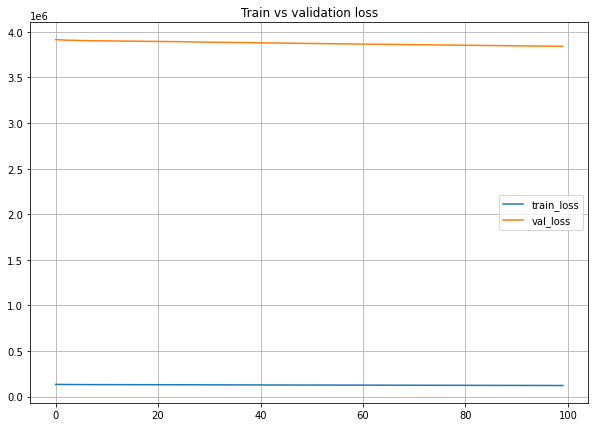

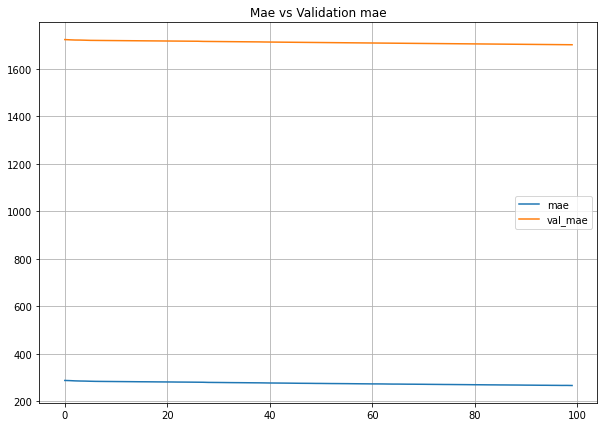

In [106]:
#Plot the learning curve
plot_mae_loss_curves(history_model_7)

## Model 8: Dense model_advanced - W30/H1

In [215]:
HORIZON = 1
WINDOW_SIZE = 30

tf.random.set_seed(42)

#Build the model 
model_8 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dropout(0.2),
                               layers.BatchNormalization(),
                               layers.Dense(64, activation="relu"),
                               layers.Dropout(0.2),
                               layers.BatchNormalization(),                              
                               layers.Dense(HORIZON)
], name="model_8_dense_advanced")

In [216]:
#Compile the model 
model_8.compile(loss="mae", optimizer="Adam", metrics=["mse", "mae"])

In [217]:
#Fit the model 
history_model_8 = model_8.fit(train_windows, train_labels, 
            verbose=0,
            epochs=250,
            batch_size=128,
            validation_data=(test_windows, test_labels))

In [218]:
model_8.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 79.3743 - mse: 15912.6650 - mae: 79.3743


[79.37428283691406, 15912.6650390625, 79.37428283691406]

In [219]:
#Make future predictions
model_8_preds = make_preds(model_8, test_windows)

#Evaluate on future predictions
model_8_results = evaluate_preds(tf.squeeze(test_labels), model_8_preds)
model_8_results

{'mae': 79.37428, 'mape': 79.37428, 'mse': 15912.665, 'rmse': 126.14541}

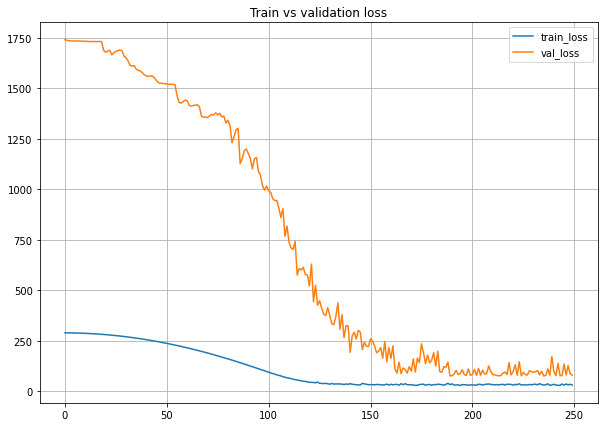

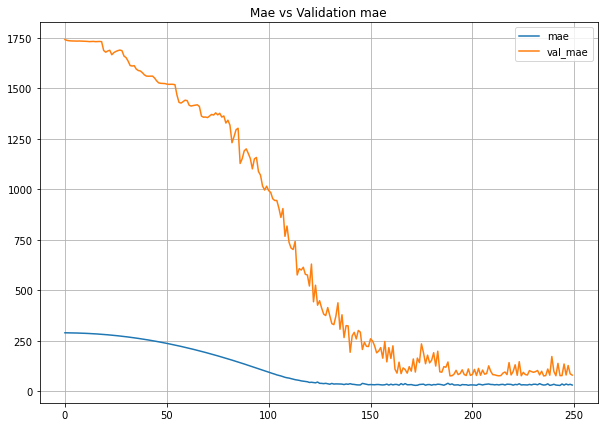

In [220]:
#Plot the learning curve
plot_mae_loss_curves(history_model_8)

## Model 9: Bidirectional LSTM W30/H1

In [308]:
tf.random.set_seed(42)

#Build the model 
model_9 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Bidirectional(layers.LSTM(128, dropout=0.2, return_sequences=True)),
                               layers.Dropout(0.2),
                               layers.BatchNormalization(),
                               layers.Bidirectional(layers.LSTM(128, dropout=0.2)),
                               layers.Dropout(0.2),
                               layers.BatchNormalization(),
                               layers.Dense(HORIZON)
], name="model_9_bi_lstm")

In [309]:
#Compile the model
model_9.compile(loss="mae", optimizer="Adam", metrics=["mae", "mse"])

In [310]:
#Fit the model 
history_model_9 = model_9.fit(train_windows, train_labels,
                              verbose=0,
                              epochs=1000,
                              batch_size=128,
                              validation_data=(test_windows, test_labels))

In [311]:
#Evaluate
model_9.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 6ms/step - loss: 1372.7240 - mae: 1372.7240 - mse: 2818557.2500


[1372.7239990234375, 1372.7239990234375, 2818557.25]

In [312]:
#Make future predictions
model_9_preds = make_preds(model_9, test_windows)

#Evaluate on future predictions
model_9_results = evaluate_preds(tf.squeeze(test_labels), model_9_preds)
model_9_results

{'mae': 1372.7241, 'mape': 1372.7241, 'mse': 2818557.2, 'rmse': 1678.856}

In [316]:
def predict_evaluate_plot(model, test_windows, test_labels, history):
  """
  Function for evaluation the trained model and plotting the training curve
  Parameters
  ---------
  model: trained model
  test_windows: test windows for validating the model
  test_labels: labels for validating the model
  history: model training history
  
  Returns dictionary with varius evaluation metrics
  """
  model_preds = make_preds(model, test_windows)
  model_results = evaluate_preds(tf.squeeze(test_labels), model_preds)
  plot_mae_loss_curves(history)
  return model_results

{'mae': 1372.7241, 'mape': 1372.7241, 'mse': 2818557.2, 'rmse': 1678.856}

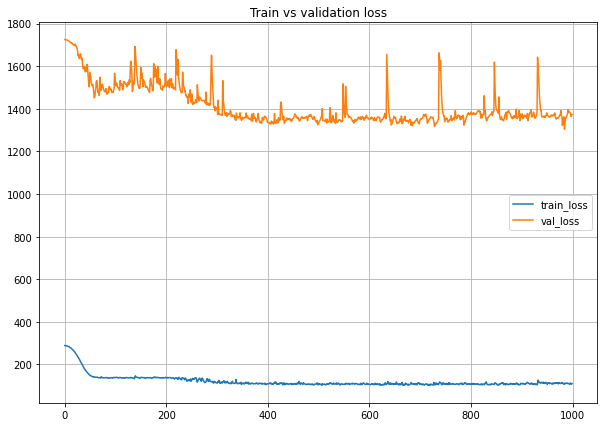

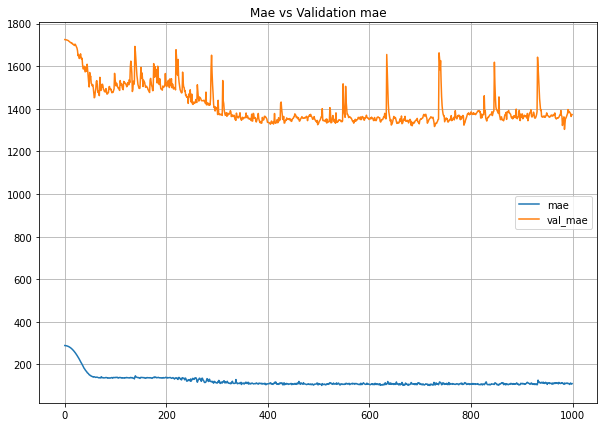

In [317]:
model_9_results = predict_evaluate_plot(model_9, test_windows, test_labels, history_model_9)
model_9_results

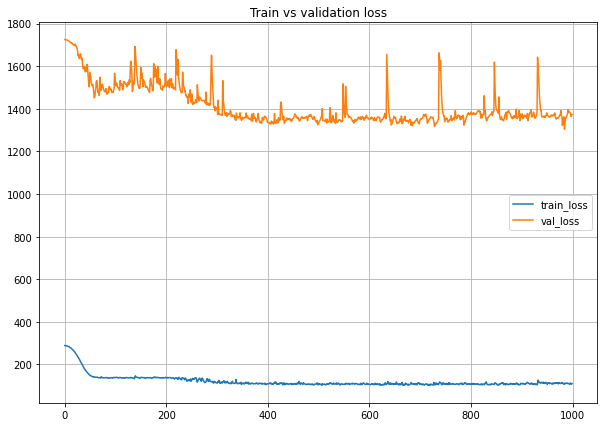

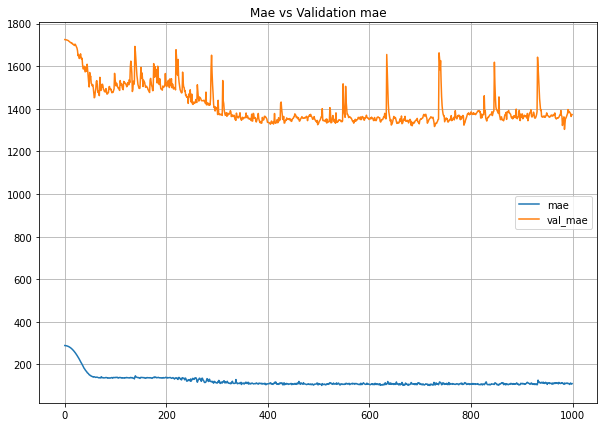

In [313]:
#Plot the learning curve
plot_mae_loss_curves(history_model_9)